In [1]:
import os

import tqdm
import fiona

import numpy as np
import rsfuncs as rs
import geopandas as gp
import pandas as pd

import numpy as np
import xarray as xr
import pandas as pd
import rsfuncs as rs
import rasterio as rio
import geopandas as gp
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

from rasterio.mask import mask
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D      

from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

In [2]:
def plot_basemaps(image, shp, title = None, cmap = 'viridis', ax = None, latlabels = True, lonlabels = True, vmax = None):
    imextent = gp.read_file(shp).set_crs("EPSG:4326").to_crs(4326).bounds
    shape_feature = ShapelyFeature(Reader("../shape/sierra_catchments.shp").geometries(),
                        ccrs.PlateCarree(), edgecolor='white', facecolor = 'none')


    lllon, lllat = imextent.minx.values[0], imextent.miny.values[0]
    urlon, urlat = imextent.maxx.values[0], imextent.maxy.values[0]

    # Create a Stamen Terrain instance.
    stamen_terrain = cimgt.Stamen('terrain-background')

    # Create a GeoAxes in the tile's projection.
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels= False
    gl.right_labels = False
    if not latlabels:
        gl.left_labels = False
    if not lonlabels:
        gl.bottom_labels = False
        
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,361))
    gl.ylocator = mticker.FixedLocator(np.linspace(0,90,91))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 9, 'color': 'gray'}
    gl.ylabel_style = {'size': 9, 'color': 'gray'}

    # Limit the extent of the map to a small longitude/latitude range.
    ax.set_extent([lllon, urlon, lllat, urlat])

    # Add the Stamen data at zoom level 8.
    ax.add_image(stamen_terrain, 8)
    
    im = ax.imshow(image,
        cmap=cmap, zorder=1, vmin = 0, vmax = vmax,
        origin="upper", alpha = 0.8,
        extent=(lllon, urlon, lllat, urlat),
        transform=ccrs.PlateCarree(),
    )

    # Add shapefile outline
    ax.add_feature(shape_feature, zorder = 2)
    
    # Set the title
    ax.set_title("{}".format(title), size = 12)

    # Set location of the colorbar
#     ax.set_aspect('auto')
    
    cbar = plt.colorbar(mappable=im,orientation='vertical', fraction=0.05, pad = 0.0125, ax = ax)
    return 

In [3]:

dswemean = np.load("/Users/aakashahamed/Desktop/snodas_box/results/mean_d.npy")
pmean = np.load("/Users/aakashahamed/Desktop/snodas_box/results/mean_p.npy")

cvws = gp.read_file("../shape/cvws.shp")
cv = gp.read_file("/Users/aakashahamed/Desktop/RS_GW/shape/cv.shp")
outlets = gp.read_file("../shape/term_res.shp")

if not os.path.exists("../rasters/dswe_annual.tif"):
    rs.write_raster(dswemean,cvws,"../rasters/dswe_annual.tif")
    
if not os.path.exists("../rasters/p_annual.tif"):
    rs.write_raster(pmean,cvws,"../rasters/p_annual.tif")

In [4]:
if not os.path.exists("../shape/plot_sa.shp"):
    sheds = gp.read_file("../shape/sierra_catchments.shp")
    snv_all = gp.read_file("../shape/snv.shp")
    pltsa = gp.GeoDataFrame(pd.concat([sheds, snv_all], ignore_index=True), crs=sheds.crs)
    pltsa.to_file("../shape/plot_sa.shp")
else:
    sa = gp.read_file("../shape/plot_sa.shp")

In [5]:
# clip rasters to shape boundary
tifs = ["../rasters/dswe_annual.tif","../rasters/p_annual.tif"]
tifs = [os.path.abspath(x) for x in tifs]

shpfn = os.path.abspath("../shape/plot_sa.shp")

for fn in tifs:
    outfn = fn.split(".tif")[0] + "_cl.tif"
    cmd = '''gdalwarp -cutline {} -crop_to_cutline -dstalpha {} {}'''.format(shpfn, fn, outfn)
    os.system(cmd)

In [10]:
psrc = rio.open("../rasters/p_annual.tif")
out, _ = mask(psrc, cv.geometry, invert=True, nodata = np.nan)
parr = out.reshape(out.shape[1], out.shape[2])

dsrc = rio.open("../rasters/dswe_annual.tif")
out, _ = mask(dsrc, cv.geometry, invert=True, nodata = np.nan)
darr = out.reshape(out.shape[1], out.shape[2])

esrc = rio.open("../rasters/hu6_srtm_dem.tif")
earr = esrc.read(1).astype(float)
earr[earr==0] = np.nan




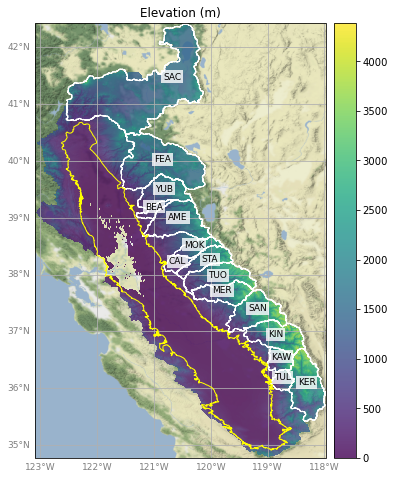

In [11]:
# Plot Elevation
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
ax1 = plot_basemaps(earr, "../shape/cvws.shp", "Elevation (m)", cmap = 'viridis', ax = axes, latlabels = True, lonlabels = True )

# Get some coords for shed labels
catchments = gp.read_file("../shape/sierra_catchments.shp")
c = catchments.copy()
c['coords'] = c['geometry'].apply(lambda x: x.representative_point().coords[:])
c['coords'] = [coords[0] for coords in c['coords']]

# Label the sheds
for idx, row in c.iterrows():
    axes.text(row.coords[0], row.coords[1], s=row['catch_name'][:3], horizontalalignment='center', size = 9,
    bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}, zorder= 5)

# plot cv
cv.plot(ax = axes, edgecolor = 'yellow', facecolor = 'none', zorder = 3)

plt.show()
    


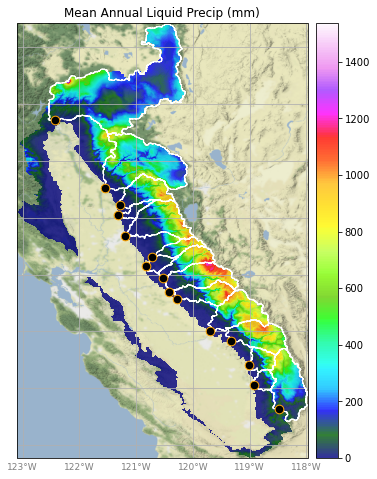

In [12]:
# Plot Precip
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(parr, "../shape/cvws.shp", "Mean Annual Liquid Precip (mm)", cmap = 'gist_ncar', ax = axes, latlabels = False, lonlabels = True )
outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'orange', zorder = 4)

plt.show()

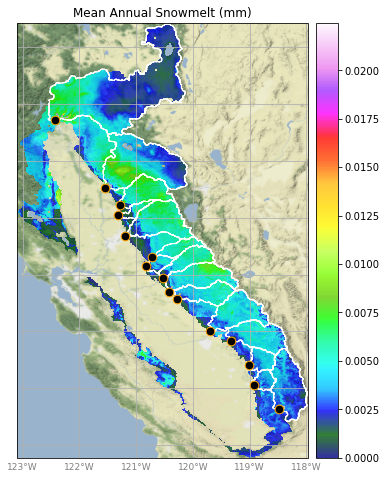

In [13]:
# Plot snowmelt
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
plot_basemaps(darr, "../shape/cvws.shp", "Mean Annual Snowmelt (mm)", cmap = 'gist_ncar', ax = axes, latlabels = False, lonlabels = True)
outlets.plot(ax = axes, color = 'black', markersize = 75, edgecolor = 'orange', zorder = 4)

plt.show()

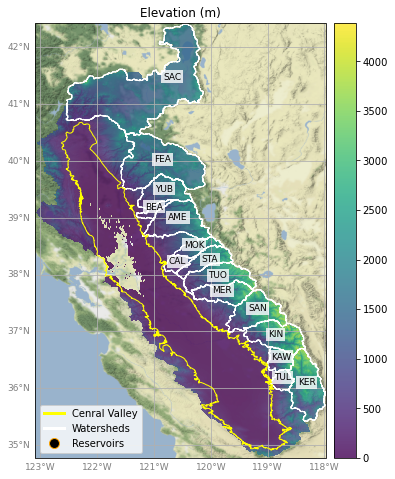

In [15]:

# Plot Elevation
fig, axes = plt.subplots(nrows=1, ncols=1,figsize = (12,8), subplot_kw={'projection': ccrs.PlateCarree()})
ax1 = plot_basemaps(earr, "../shape/cvws.shp", "Elevation (m)", cmap = 'viridis', ax = axes, latlabels = True, lonlabels = True )

# Get some coords for shed labels
catchments = gp.read_file("../shape/sierra_catchments.shp")
c = catchments.copy()
c['coords'] = c['geometry'].apply(lambda x: x.representative_point().coords[:])
c['coords'] = [coords[0] for coords in c['coords']]

# Label the sheds
for idx, row in c.iterrows():
    axes.text(row.coords[0], row.coords[1], s=row['catch_name'][:3], horizontalalignment='center', size = 9,
    bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'}, zorder= 5)

# plot cv
cv.plot(ax = axes, edgecolor = 'yellow', facecolor = 'none', zorder = 3)

# cv_patch = Line2D(color='yellow', label='Central Valley')
cv_patch = Line2D([0],[0],color='yellow',label='Cenral Valley', lw=3)
# shed_patch = Line2D(color='white', label='Watersheds')
shed_patch = Line2D([0],[0],color='white',label='Watersheds', lw=3)
# res_patch = mpatches.Circle(color='black',edgecolor = 'orange', label='Reservoirs')
res_patch = Line2D([0],[0],marker='o',markersize=10,color='black', markeredgecolor = 'orange',label='Reservoirs', lw=0)

plt.legend(handles=[cv_patch, shed_patch, res_patch], loc = 'lower left')

plt.show()
